In [6]:
import bilby
from bilby.core.utils import random
import pprint
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bilby.gw.conversion as conv

random.seed(123)


#select merger number
i = 0

outdir = "outdir"
label_raw = "bns_eos"
label = label_raw + str(i)
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)
# bilby.core.utils.setup_logger(outdir=outdir, label=label)

def physical_to_dimensionless(l, m):
    return (l * 1e36 * (2.99792458e10)**10 / (6.67430e-8**4 * (m * 1.9885e33)**5))

# physical lambda values for masses come from SLY Curve in Fig 2 of https://arxiv.org/pdf/0911.3535
physical_lambdas = [1.7404580152671756, 1.6259541984732824, 1.4885496183206106, 1.3511450381679388, 1.16793893129771, 0.9847328244274809, 0.8015267175572519, 0.5954198473282443]

masses = [0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
# lambdas = [physical_to_dimensionless(physical_lambdas[i], masses[i]) for i in range(len(physical_lambdas))]
lambdas = [2801, 1545, 878, 516, 298, 174, 100, 53]

distances = [30, 40, 50, 60] 

#everything except masses, lambdas, distance
ip_template = dict(
    chi_1=0.02,
    chi_2=0.02,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2_NRTidal",
    reference_frequency=50.0,
    minimum_frequency=40.0,
    fiducial=1
)

duration = 32
sampling_frequency = 2048
start_time = ip_template["geocent_time"] + 2 - duration


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star_relative_binning,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)

#build ip
ip = ip_template.copy()
ip["mass_2"], ip["mass_1"] = masses[2*i], masses[2*i+1]
ip["lambda_2"], ip["lambda_1"] = lambdas[2*i], lambdas[2*i+1]
ip["luminosity_distance"] = distances[i]

ifo = bilby.gw.detector.InterferometerList(["CE"])
for interferometer in ifo:
    interferometer.minimum_frequency = 50

ifo.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency, duration=duration, start_time=start_time)
ifo.inject_signal(parameters=ip, waveform_generator=waveform_generator)

priors = bilby.gw.prior.BNSPriorDict()
for key in [
    "psi",
    "geocent_time",
    "ra",
    "dec",
    "chi_1",
    "chi_2",
    "theta_jn",
    "luminosity_distance",
    "phase",
]:
    priors[key] = ip[key]

del priors["mass_ratio"], priors["lambda_1"], priors["lambda_2"]

m1, m2 = ip["mass_1"], ip["mass_2"]

priors["chirp_mass"] =  bilby.core.prior.Uniform(0.5, 1.5, name="chirp_mass", unit="$M_{\\odot}$")
priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(0.1, 0.25, name="symmetric_mass_ratio")
priors["lambda_tilde"] = bilby.core.prior.Uniform(0, 2500, name="lambda_tilde")
priors["delta_lambda_tilde"] = bilby.core.prior.Uniform(0, 150, name="delta_lambda_tilde")


priors["lambda_1"] = bilby.core.prior.Constraint(name="lambda_1", minimum=0, maximum=5000)
priors["lambda_2"] = bilby.core.prior.Constraint(name="lambda_2", minimum=0, maximum=5000)

fp = ip.copy()

m1 = fp.pop("mass_1")
m2 = fp.pop("mass_2")
l1 = fp.pop("lambda_1")
l2 = fp.pop("lambda_2")

fp["chirp_mass"] = (bilby.gw.conversion.component_masses_to_chirp_mass(m1, m2))
fp["symmetric_mass_ratio"] = (bilby.gw.conversion.component_masses_to_symmetric_mass_ratio(m1, m2))
fp["lambda_tilde"] = (bilby.gw.conversion.lambda_1_lambda_2_to_lambda_tilde(l1, l2, m1, m2))
fp["delta_lambda_tilde"] = (bilby.gw.conversion.lambda_1_lambda_2_to_delta_lambda_tilde(l1, l2, m1, m2))


likelihood = bilby.gw.likelihood.RelativeBinningGravitationalWaveTransient(
    interferometers=ifo,
    waveform_generator=waveform_generator,
    priors=priors,
    fiducial_parameters=fp,
)

# result = bilby.run_sampler(
#     likelihood=likelihood,
#     priors=priors,
#     sampler="nestle",
#     npoints=100,
#     injection_parameters=ip,
#     outdir=outdir,
#     label=label,
#     conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
#     result_class=bilby.gw.result.CBCResult,
# )

# print("finished merger", i)

00:33 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=32, sampling_frequency=2048, start_time=0, frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star_relative_binning, time_domain_source_model=None, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters, waveform_arguments={'waveform_approximant': 'IMRPhenomPv2_NRTidal', 'reference_frequency': 50.0, 'minimum_frequency': 40.0, 'fiducial': 1})
00:33 bilby INFO    : Injected signal in CE:
00:33 bilby INFO    :   optimal SNR = 967.47
00:33 bilby INFO    :   matched filter SNR = 966.45-0.09j
00:33 bilby INFO    :   chi_1 = 0.02
00:33 bilby INFO    :   chi_2 = 0.02
00:33 bilby INFO    :   theta_jn = 0.4
00:33 bilby INFO    :   psi = 2.659
00:33 bilby INFO    :   phase = 1.3
00:33 bilby INFO    :   geocent_time = 1126259642.413
00:33 bilby INFO    :   ra = 1.375
00:33 bilby INFO    :   dec = -1.2108
00:33 bilby INFO    :   mass_2 = 0.9
00:33 bilby INFO    :   mass_1 

In [7]:

#read in result objects from outdir

results = {}
posteriors = {} # in the new parameters!

for i in range(4):
    res = bilby.core.result.read_in_result(f"{outdir}/{label_raw}{i}_result.json")
    results[i] = res
    # posteriors[i] = results[i].posterior
    df = pd.DataFrame()
    df["mass_1"], df["mass_2"] = conv.chirp_mass_and_mass_ratio_to_component_masses(res.posterior["chirp_mass"], conv.symmetric_mass_ratio_to_mass_ratio(res.posterior["symmetric_mass_ratio"]))
    df["lambda_1"], df["lambda_2"] = conv.lambda_tilde_delta_lambda_tilde_to_lambda_1_lambda_2(res.posterior["lambda_tilde"], res.posterior["delta_lambda_tilde"], df["mass_1"], df["mass_2"])
    posteriors[i] = df
    
    


In [23]:
#
theory_masses = [0.9486033519553072, 1.0558659217877095, 1.146368715083799, 1.2368715083798882, 1.3407821229050279, 1.4279329608938547, 1.5519553072625698, 0.8949720670391061, 0.8782122905027933, 0.8782122905027933, 0.9217877094972067, 0.9754189944134078, 0.9988826815642458, 1.035754189944134, 1.0223463687150838, 1.0223463687150838, 1.0793296089385476, 1.1027932960893854, 1.1229050279329609, 1.1664804469273742, 1.193296089385475, 1.2167597765363127, 1.2368715083798882, 1.2569832402234637, 1.2804469273743015, 1.3173184357541898, 1.3039106145251396, 1.3642458100558659, 1.387709497206704, 1.411173184357542, 1.43463687150838, 1.43463687150838, 1.4547486033519552, 1.4782122905027932, 1.5016759776536313, 1.5217877094972068, 1.5519553072625698, 1.5754189944134078, 1.5988826815642458]

theory_phys_lambda = [1.7166666666666666, 1.5666666666666667, 1.4333333333333333, 1.3, 1.1, 0.9333333333333333, 0.7166666666666667, 1.7666666666666666, 1.7833333333333332, 1.7833333333333332, 1.75, 1.6833333333333333, 1.65, 1.6, 1.6333333333333333, 1.6333333333333333, 1.5333333333333332, 1.5, 1.4833333333333334, 1.4, 1.3666666666666667, 1.3333333333333333, 1.3, 1.25, 1.2166666666666666, 1.15, 1.1666666666666667, 1.0666666666666667, 1.0333333333333332, 0.9833333333333333, 0.9333333333333333, 0.9333333333333333, 0.9, 0.8666666666666667, 0.8166666666666667, 0.7666666666666666, 0.7166666666666667, 0.6666666666666666, 0.6166666666666667]

theory_lambdas = [physical_to_dimensionless(theory_phys_lambda[i], theory_masses[i]) for i in range(len(theory_phys_lambda))]

theory_masses.sort()
theory_lambdas.sort(reverse=True)

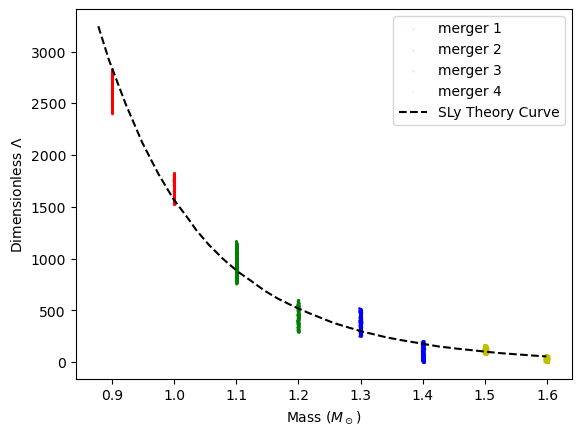

In [39]:
# plot posteriors

fig, ax = plt.subplots()
colors = ["r", "g", "b", "y"]

for i in range(4):
    df = posteriors[i]
    ax.scatter(df["mass_1"], df["lambda_1"], alpha = 0.1, s = 0.5, c=colors[i], label = f"merger {i+1}")
    ax.scatter(df["mass_2"], df["lambda_2"], alpha = 0.1, s = 0.5, c=colors[i])


#plot theory curve 
ax.plot(theory_masses, theory_lambdas, "k--", label = "SLy Theory Curve")

ax.set_xlabel(r"Mass $(M_\odot)$")
ax.set_ylabel(r"Dimensionless $\Lambda$")
ax.legend()